# [Computational Social Science]
## 5-3 Text Feature Engineering and Classification - Student Version

In this lab we will use the techniques we covered so far to engineer text features and train a classification algorithm.

## Virtual Environment
Remember to always activate your virtual environment first before you install packages or run a notebook! This helps to prevent conflicts between dependencies across different projects and ensures that you are using the correct versions of packages. You must have created anaconda virtual enviornment in the `Anaconda Installation` lab. If you have not or want to create a new virtual environment, follow the instruction in the `Anaconda Installation` lab. 

<br>

If you have already created a virtual enviornment, you can run the following command to activate it: 

<br>

`conda activate <virtual_env_name>`

<br>

For example, if your virtual environment was named as CSS, run the following command. 

<br>

`conda activate CSS`

<br>

To deactivate your virtual environment after you are done working with the lab, run the following command. 

<br>

`conda deactivate`

<br>

In [1]:
# load libraries
# ----------
import pandas as pd
import numpy as np
import spacy
import en_core_web_sm
nlp = en_core_web_sm.load()
from spacy.lang.en.stop_words import STOP_WORDS
from string import punctuation
from textblob import TextBlob
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import LabelBinarizer
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
import seaborn as sns
import matplotlib.pyplot as plt

# settings
%matplotlib inline

## Data

<img src = "../../images/cfpb_logo.png"/>

We'll once again use the Consumer Financial Protection Bureau's [Consumer Complaint Database](https://www.consumerfinance.gov/data-research/consumer-complaints/). Picking up from where we left off last time, we'll focus on predicting whether a consumer complaint narrative is talking about a "checkings or savings account" issue or a "student loan" issue.

In [3]:
# load the data
# ----------
# load data
cfpb = pd.read_csv("data/CFPB 2020 Complaints.csv")

# drop missing on "Consumer complaint narrative" feature and reset the index bc we've dropped
cfpb = cfpb.dropna(subset = ['Consumer complaint narrative'])

# filtering to keep only savings and student loan products
cfpb = cfpb[(cfpb['Product']=='Checking or savings account') | (cfpb['Product'] == 'Student loan')]

# filtering to keep the first 1000 rows
cfpb = cfpb[:1000]

In [5]:
cfpb['Consumer complaint narrative']

99       XXXX the XXXX I lost my card on a lunch run wh...
234      In response to your answer dated XX/XX/XXXX. Y...
332      On XX/XX/2020, my wife and I opened a business...
346      I signed up and opened a citibank checking acc...
397      On XX/XX/2020, the CARES Act was signed into f...
                               ...                        
42908    My student loans were serviced by Navient. Cir...
43000    On or about XXXX XXXX XXXX 2019 I used my debi...
43048    On XX/XX/XXXX, I received a fraud check from a...
43049    Im filing a complaint against Ascendium/XXXX  ...
43054    I believe I was taken advantage of Wells Fargo...
Name: Consumer complaint narrative, Length: 1000, dtype: object

## Text Preprocessing

Before we do any feature engineering or classification, we should first preprocess our text. Let's start by adding custom stop words and defining our custom `rem_punc_stop()` function:

In [18]:
# add a few words analysis-specific words to our Stop Words
# ----------
STOP_WORDS = STOP_WORDS.union({"xx", "xxxx","xxxxxxxx","ll", "ve"})

# what are some ways we might check to see if these stop words were added
# ----------

# option 1
... 

# option 2
... 

Ellipsis

**CHALLENGE:** Label what each line is doing. See the "Solutions" notebook for answers 

In [19]:
# create preprocessing function - like we have in the past few labs 
# ----------

def rem_punc_stop(text):
    
    # add more stop words
    stop_words = STOP_WORDS     
    punc = set(punctuation)
    
    # remove the punctuation
    punc_free = "".join([ch for ch in text if ch not in punc])                                                               

    # apply nlp to punctuation-free object
    doc = nlp(punc_free)
    
    # lemmatize
    text_lemma = " ".join([word.lemma_ for word in doc])
    
    # extract words from processed text 
    spacy_words = text_lemma.split()
    spacy_words_1 = [word for word in spacy_words if not word.startswith("X")]
    spacy_words_2 = [word for word in spacy_words_1 if not word.startswith("x")]
    
    
    # filter out words 
    no_stop = [word for word in spacy_words_2 if word not in stop_words]
    
    # return
    return no_stop

Now let's go ahead and apply our function to the consumer complaint narratives. Notice how the `rem_punc_stop()` function returns a list, but we can collapse our tokens back into strings with the `join()` string method.

Note that this will take a few moments to run, so be patient. 


**CHALLENGE:** This code has been altered from the solutions script to produce an error. What is the error? and how woudl you fix it. 

In [20]:
# apply our preprocessing function to the consumer complaint column in our original dataframe
# ----------

# remove punctuation and stop words
cfpb['tokens'] = cfpb['Consumer complaint narrative'].map(lambda x: rem_punc_stop(x))

# collapse tokens in a string using join method since output of last step is a list
cfpb['tokens'] = cfpb['tokens'].map(lambda text: ' '.join(text))

# view
cfpb['tokens']

99       I lose card lunch run break lunch I realize I ...
234      response answer date state USAA utilize Title ...
332      wife I open business account Navy Federal Cred...
346      I sign open citibank checking account late adv...
397      CARES Act sign federal law indicate borrower f...
                               ...                        
42908    student loan service Navient Circa 2012 Navien...
43000    2019 I use debit card purchase deny investigat...
43048    I receive fraud check fake company contact I c...
43049    I m file complaint ascendiumxxxx Department Ed...
43054    I believe I advantage Wells Fargo Bank close a...
Name: tokens, Length: 1000, dtype: object

## Wrap up EDA

We've already explored several exploratory data analysis techniques. There are many different ways to explore text data that we haven't covered, but let's take a look at one last basic tool: visualizing n-grams.  

In [38]:
# initialize the Bag-of-Words CounterVectorizer
# ----------
# notice the ngram_range argument
countvec = CountVectorizer(stop_words=list(STOP_WORDS), # specify a list of stop words to extract 
                           ngram_range=(2,3))           # specify bi- and trigrams 

# fit and transform on tokens
ngrams = countvec.fit_transform(cfpb['tokens'])         

# create a dataframe out of ngram sparse matrix
dictionary_dataframe = pd.DataFrame(ngrams.todense(), # why do you need to specify tondense() here?
                                    columns = countvec.get_feature_names_out()) # get features

In [39]:
# create dataframe of n-grams and their frequency 
# ----------

# create a datamframe by summing over the dictionary_dataframe from above and resetting the index
df_ngram = pd.DataFrame(dictionary_dataframe.sum().reset_index()).rename(columns={'index': 'ngrams', 0:'freq'})

#  sort by frequency 
df_ngram = df_ngram.sort_values(by = ['freq'], 
                                ascending = False).reset_index(drop = True)

# view the first few lines
df_ngram.head()

,ngrams,freq
0,wells fargo,337
1,student loan,240
2,debit card,216
3,bank america,199
4,checking account,190


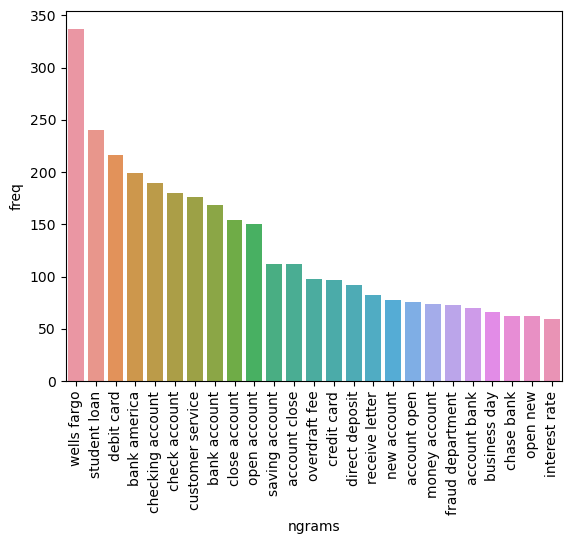

In [40]:
# create bar plot visualization
# ----------
sns.barplot(x="ngrams",    # what goes on the x-axis here?
            y = 'freq',  # what goes on the y-axis here?
            data=df_ngram[0:25])
plt.xticks(rotation=90)
plt.show()

**CHALLENGE:** Adjust the code above to visualize the most popular unigrams and 4-grams. What is the tradeoff involved with increasing n?

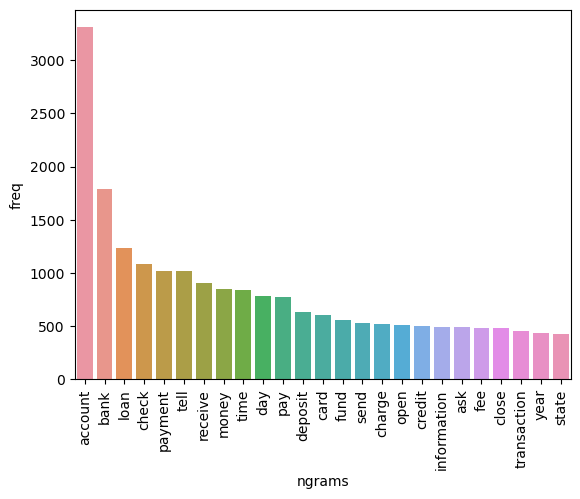

In [47]:
# adjust to count unigrams 
# ----------

# ----------
# notice the ngram_range argument
countvec = CountVectorizer(stop_words=list(STOP_WORDS), # specify a list of stop words to extract 
                           ngram_range=(1,1))           # specify bi- and trigrams 

# fit and transform on tokens
ngrams = countvec.fit_transform(cfpb['tokens'])         

# create a dataframe out of ngram sparse matrix
dictionary_dataframe = pd.DataFrame(ngrams.todense(), # why do you need to specify tondense() here?
                                    columns = countvec.get_feature_names_out()) # get features



# create dataframe of n-grams and their frequency 
# ----------

# create a datamframe by summing over the dictionary_dataframe from above and resetting the index
df_ngram = pd.DataFrame(dictionary_dataframe.sum().reset_index()).rename(columns={'index': 'ngrams', 0:'freq'})

#  sort by frequency 
df_ngram = df_ngram.sort_values(by = ['freq'], 
                                ascending = False).reset_index(drop = True)



# create bar plot visualization
# ----------
sns.barplot(x="ngrams",    # what goes on the x-axis here?
            y = 'freq',  # what goes on the y-axis here?
            data=df_ngram[0:25])
plt.xticks(rotation=90)
plt.show()

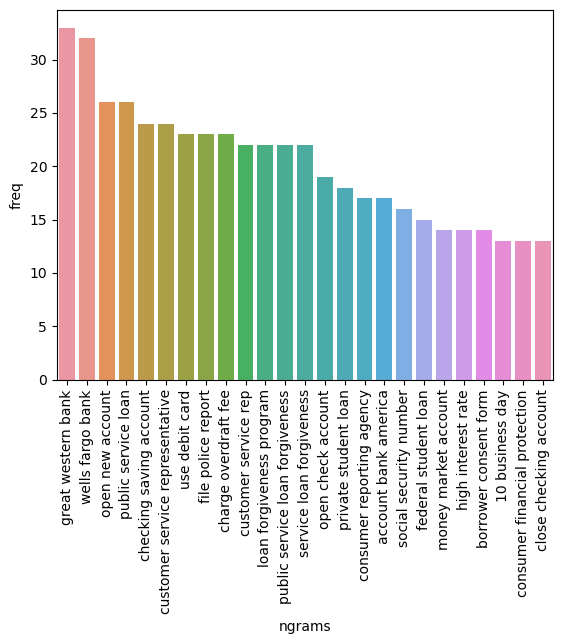

In [49]:
# adjust to count 4-grams
# ----------

# notice the ngram_range argument
countvec = CountVectorizer(stop_words=list(STOP_WORDS), # specify a list of stop words to extract 
                           ngram_range=(3,4))           # specify bi- and trigrams 

# fit and transform on tokens
ngrams = countvec.fit_transform(cfpb['tokens'])         

# create a dataframe out of ngram sparse matrix
dictionary_dataframe = pd.DataFrame(ngrams.todense(), # why do you need to specify tondense() here?
                                    columns = countvec.get_feature_names_out()) # get features



# create dataframe of n-grams and their frequency 
# ----------

# create a datamframe by summing over the dictionary_dataframe from above and resetting the index
df_ngram = pd.DataFrame(dictionary_dataframe.sum().reset_index()).rename(columns={'index': 'ngrams', 0:'freq'})

#  sort by frequency 
df_ngram = df_ngram.sort_values(by = ['freq'], 
                                ascending = False).reset_index(drop = True)



# create bar plot visualization
# ----------
sns.barplot(x="ngrams",    # what goes on the x-axis here?
            y = 'freq',  # what goes on the y-axis here?
            data=df_ngram[0:25])
plt.xticks(rotation=90)
plt.show()

**ANSWER**: ...

## Feature Engineering

Last time, we saw some techniques for exploring the text of our data. Specifically, we saw how to find the length of our text and word counts. How can we do this?

In [51]:
# find the character count for each document 
# --------
# apply length function to tokens column to count each character - what 
cfpb['complaint_len'] = cfpb['tokens'].apply(len)

# view the new feature we just created
cfpb[['tokens', 'complaint_len']]

,tokens,complaint_len
99,I lose card lunch run break lunch I realize I ...,336
234,response answer date state USAA utilize Title ...,435
332,wife I open business account Navy Federal Cred...,196
346,I sign open citibank checking account late adv...,163
397,CARES Act sign federal law indicate borrower f...,1019
...,...,...
42908,student loan service Navient Circa 2012 Navien...,492
43000,2019 I use debit card purchase deny investigat...,583
43048,I receive fraud check fake company contact I c...,874
43049,I m file complaint ascendiumxxxx Department Ed...,836


In [52]:
# find the word count for each document 
# --------
# apply length function to tokens column to count words -- you will need to split the text to count words
cfpb['word_count'] = cfpb['tokens'].apply(lambda x: len(str(x).split()))

# view
cfpb[['tokens', 'complaint_len', 'word_count']]

,tokens,complaint_len,word_count
99,I lose card lunch run break lunch I realize I ...,336,61
234,response answer date state USAA utilize Title ...,435,67
332,wife I open business account Navy Federal Cred...,196,29
346,I sign open citibank checking account late adv...,163,29
397,CARES Act sign federal law indicate borrower f...,1019,135
...,...,...,...
42908,student loan service Navient Circa 2012 Navien...,492,70
43000,2019 I use debit card purchase deny investigat...,583,97
43048,I receive fraud check fake company contact I c...,874,155
43049,I m file complaint ascendiumxxxx Department Ed...,836,135


We also covered subjectivity and sentiment:

In [53]:
# create polarity and subjectivity features
# --------
cfpb['polarity'] = cfpb['tokens'].map(lambda text: TextBlob(text).sentiment.polarity)
cfpb['subjectivity'] = cfpb['tokens'].map(lambda text: TextBlob(text).sentiment.subjectivity)

# view
cfpb[['tokens', 'complaint_len', 'word_count', 'polarity', 'subjectivity']]

,tokens,complaint_len,word_count,polarity,subjectivity
99,I lose card lunch run break lunch I realize I ...,336,61,-0.010385,0.538846
234,response answer date state USAA utilize Title ...,435,67,0.500000,0.500000
332,wife I open business account Navy Federal Cred...,196,29,0.000000,0.500000
346,I sign open citibank checking account late adv...,163,29,-0.066667,0.500000
397,CARES Act sign federal law indicate borrower f...,1019,135,0.018182,0.390093
...,...,...,...,...,...
42908,student loan service Navient Circa 2012 Navien...,492,70,0.033333,0.352778
43000,2019 I use debit card purchase deny investigat...,583,97,0.000584,0.398474
43048,I receive fraud check fake company contact I c...,874,155,0.063714,0.593071
43049,I m file complaint ascendiumxxxx Department Ed...,836,135,-0.182500,0.517500


### Build a Dictionary

Before we continue, let's take the top 25 n-grams we found earlier and turn them into their own dataframe. We'll return to these later.

In [54]:
# build a dictionary
# --------

# create a count of words after dropping stop words
countvec = CountVectorizer(stop_words=list(STOP_WORDS),  # use our list of stop words
                           ngram_range=(2,3))            # specify bi- and tri-grams

# apply countvec function to our tokenized data
ngrams = countvec.fit_transform(cfpb['tokens'])

# create dictionary - but note 
dictionary_dataframe = pd.DataFrame(ngrams.todense(), 
                                    columns = countvec.get_feature_names_out())


# create ngram frequency dataframe by summing over dictionary dataframe
df_ngram = pd.DataFrame(dictionary_dataframe.sum().reset_index()).rename(columns={'index': 'ngrams', 0:'freq'})
df_ngram = df_ngram.sort_values(by = ['freq'], 
                                ascending = False).reset_index(drop = True)

# view just a subset
top_25_ngrams = dictionary_dataframe.loc[:,df_ngram[0:25]['ngrams']]
top_25_ngrams.head()

,wells fargo,student loan,debit card,bank america,checking account,check account,customer service,bank account,close account,open account,...,receive letter,new account,account open,money account,fraud department,account bank,business day,chase bank,open new,interest rate
0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,2,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Challenge: Topic Modeling

Using the code we went over from the last lab, make a dataframe with 5 LDA generated topics. Then, create a topic model using [Non-Negative Matrix Factorization](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html) and print out the words associated with the first 5 topics. NMF is another algorithm that is frequently used for topic modeling. 

**QUESTION:** Do you get similar topics as with your LDA topics? 

In [55]:
# first, let's define a function to print the top words that we'll use in our model
# --------

def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #{}:".format(topic_idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

In [60]:
#
# Latent Dirichlet Allocation (LDA)
# ---------------------------------------

# pre-processing
# --------
# create a new data object called X
X = cfpb['tokens']

# initialize tf-idf function and set parameters
tf = TfidfVectorizer(tokenizer = rem_punc_stop, # use our function for tokenizing created above
                     token_pattern = None)       # what can we add here to remove the Warning? Is this necessary?


# apply tf-idf vectorizer to our data (X)
tfidf_matrix =  tf.fit_transform(X)  # specify correct data ehre

# modify the output to be a dense matrix
dense_matrix = tfidf_matrix.todense() # how do we densify this matrix?

# intitialize LDA model and 
# --------
# initialize LDA and set model parameters
lda = LatentDirichletAllocation(n_components=5,            # specify 5 components
                                max_iter=20,            # specify 20 iterations 
                                random_state=0) # set seed of 0 for  reproducibility

# fit LDA model to our dense matrix
lda = lda.fit(np.asarray(dense_matrix))

# post-processing
# --------
# get feature names from our tf-idf vector
tf_feature_names = tf.get_feature_names_out()

# print top words 
print_top_words(lda,  # specify LDA model
                tf_feature_names,  # specify feature names vector
                20)  # specify that we want to see 20 words here
 

# now transform our data using the lda model and create a dataframe
topic_dist = lda.transform(tfidf_matrix)
topic_dist_df = pd.DataFrame(topic_dist).reset_index(drop = True)

# view the corresponding tf-idf dataframe with tf-idf values
topic_dist_df


Topic #0:
bmo harris credit lately days60 unfavorable misreport days120 aforesaid seriously greatly tune particular relation prefer highly accordance recommend generate fair

Topic #1:
delta robinhood 42000 ombudsman disaster horizon continuous levy plc firstbankpr firstbank pr clearance associates ecmc 2023 self science lousy crooked

Topic #2:
I account bank loan check payment money tell receive pay fee time deposit charge day card close fund open credit

Topic #3:
amex aplie brink mastercard companycreditor inaccurately prepay ihave optin optout acima 5700 dish couch washer suffering wavy empathy waiver optedin

Topic #4:
barrow popular coop unathorized renasant wrongfully 4600 pymt tech inactivity trial ar3 partnership amt embezzlement timexxxx pant 2014 pymts 4700



,0,1,2,3,4
0,0.030579,0.030566,0.877723,0.030566,0.030566
1,0.028545,0.028453,0.886096,0.028453,0.028453
2,0.038145,0.037881,0.848211,0.037881,0.037881
3,0.035714,0.035625,0.857411,0.035625,0.035625
4,0.023857,0.023610,0.905311,0.023611,0.023611
...,...,...,...,...,...
995,0.027882,0.027874,0.888497,0.027874,0.027874
996,0.024225,0.024204,0.903164,0.024204,0.024204
997,0.023944,0.023936,0.904246,0.023937,0.023937
998,0.024902,0.024878,0.900465,0.024878,0.024878


In [56]:
#
# Non-Negative Matrix Factorization (NMF)
# ---------------------------------------

# pre-processing
# --------
# create a new data object called X
X = cfpb['tokens']

# initialize tf-idf function and set parameters
tf = TfidfVectorizer(tokenizer = rem_punc_stop,  # specify our function for remove punc and stop words
                     token_pattern = None)       # specify "None" to remove warning. Is this necessary?

# apply tf-idf vectorizer to our data (X)
tfidf_matrix =  tf.fit_transform(X)

# modify the output to be a dense matrix
dense_matrix = tfidf_matrix.todense()

# intitialize LDA model and 
# --------
# initialize LDA and set model parameters
nmf = NMF(n_components = 5,             # specify the number of components to 5
          init = 'random',             # specify a random initalization method
          random_state=1)  # set a seed for reproducibility

# fit NMF model to our dense matrix
nmf = nmf.fit(np.asarray(dense_matrix))

# post-processing
# --------
# get feature names from our tf-idf vector
tf_feature_names = tf.get_feature_names_out()

# print top words 
print_top_words(nmf,               # specify model
                tf_feature_names,  # specify feature names vector
                20)                # specify how many words we want to see


# now transform our data using the lda model and create a dataframe
nmf_topic_dist = nmf.transform(tfidf_matrix)
nmf_topic_dist_df = pd.DataFrame(nmf_topic_dist).reset_index(drop = True)

# view the corresponding tf-idf dataframe with tf-idf values
nmf_topic_dist_df


Topic #0:
I bank account check tell money card close transaction branch claim time fund send hold fraud receive ask deposit number

Topic #1:
credit unfavorable days60 aforesaid misreport days120 lately tune prefer relation particular seriously highly accordance reporting greatly recommend generate item fair

Topic #2:
account bonus open citibank requirement receive deposit I day offer citi new check meet direct close promotion balance 60 chase

Topic #3:
fee charge fargo wells overdraft account I bank fund cause transaction balance refund complaint payment post negative pay despite nsf

Topic #4:
loan I payment navient student pay interest year program repayment month forgiveness apply school plan fedloan forbearance income time company



,0,1,2,3,4
0,0.057437,0.000000,0.000000,0.000111,0.000000
1,0.007466,0.012602,0.020425,0.008617,0.004456
2,0.000541,0.024751,0.025816,0.007418,0.032256
3,0.012411,0.018303,0.091149,0.000000,0.016264
4,0.000000,0.007497,0.000000,0.001804,0.072220
...,...,...,...,...,...
995,0.000000,0.000000,0.003945,0.000000,0.149232
996,0.053538,0.001715,0.000000,0.017858,0.000000
997,0.049562,0.000000,0.000000,0.024688,0.000000
998,0.016012,0.009745,0.000000,0.000000,0.107071


**ANSWER**: 

## Classification

Now we're ready to move to classification! We are going to examine how different featurization techniques compare. Create a list with the following:
 * Text Engineered Features
 * Text Engineered Features + Topic Model
 * Non-Text Features only
 * Non-Text Features + Text Engineered Features
 * Tf-idf
 * Non-Text Features + tf-idf
 * Non-Text Features + Top 25 n-gram

You'll need to use pandas to create and .`join()` these different dataframes together. Also be sure to use `reset_index()` as necessary. Once you've created each of these dataframes (or arrays!) you should loop through all of them, train a supervised learning algorithm (like logistic regression or a decision tree classifier), and plot confusion matrices. Once you do this, think about which featurization technique worked the best, and whether combining text and non-text features was helpful. For now, don't worry about hyperparameter tuning or feature selection, though you would do these in practice.

In [61]:
# let's first take a look at the column names to get a sense of what we have
# --------
cfpb.columns

Index(['Date received', 'Product', 'Sub-product', 'Issue', 'Sub-issue',
       'Consumer complaint narrative', 'Company public response', 'Company',
       'State', 'ZIP code', 'Tags', 'Consumer consent provided?',
       'Submitted via', 'Date sent to company', 'Company response to consumer',
       'Timely response?', 'Consumer disputed?', 'Complaint ID', 'tokens',
       'complaint_len', 'word_count', 'polarity', 'subjectivity'],
      dtype='object')

In [72]:
non_text_with_ngrams

,Company public response_Company believes complaint caused principally by actions of third party outside the control or direction of the company,Company public response_Company believes complaint represents an opportunity for improvement to better serve consumers,Company public response_Company believes it acted appropriately as authorized by contract or law,Company public response_Company believes the complaint is the result of a misunderstanding,Company public response_Company has responded to the consumer and the CFPB and chooses not to provide a public response,Company_ACCESS GROUP INC.,"Company_ACIMA CREDIT, LLC",Company_ACS Education Services,Company_AES/PHEAA,Company_ALASKA COMMISSION ON POST SECONDARY EDUCATION,...,receive letter,new account,account open,money account,fraud department,account bank,business day,chase bank,open new,interest rate
0,False,False,False,False,True,False,False,False,False,False,...,0,0,0,0,0,0,0,0,0,0
1,False,False,True,False,False,False,False,False,False,False,...,0,0,0,0,0,0,0,0,0,0
2,False,False,True,False,False,False,False,False,False,False,...,0,0,0,0,0,0,0,0,0,0
3,False,False,False,False,True,False,False,False,False,False,...,0,0,0,0,0,0,0,0,0,0
4,False,False,False,False,False,False,False,False,True,False,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,False,False,False,False,False,False,False,False,False,False,...,0,0,0,0,0,0,0,0,0,0
996,False,False,False,False,True,False,False,False,False,False,...,1,0,0,0,0,0,0,0,0,0
997,False,False,False,False,True,False,False,False,False,False,...,0,0,0,1,0,0,1,0,0,0
998,False,False,False,False,False,False,False,False,False,False,...,0,0,0,0,0,0,0,0,0,0


In [62]:
#
# pre-processing for a classification model
# ---------------------------------------


# Engineered Text Features
# --------
# select engineered text features   # specify 4 engineered text features from above
engineered_features = cfpb[['complaint_len', 
                            'word_count', 
                            'polarity', 
                            'subjectivity']].reset_index(drop = True)

# Topic Model + Engineered Features
# --------
# combine results from our topic model + engineered features
engineered_features_with_topics = topic_dist_df.join(engineered_features.reset_index(drop = True)) # engineered features


# Non-text features
# --------
# select non-text features
non_text_features = cfpb[['Company public response', 
                          'Company',
                          'State', 
                          'Consumer consent provided?',
                          'Submitted via', 
                          'Company response to consumer',
                          'Timely response?']]

# get dummies of non-text features
non_text_features_dummies = pd.get_dummies(non_text_features).reset_index(drop = True) # get dummies of non_text_features



# Non-text features + engineered features
# --------
# combine non-text features + engineered features with topics
non_text_engineered_features = non_text_features_dummies.reset_index(drop = True).join(engineered_features_with_topics)


# Non-text features + tfidf
# --------

# create dataframe of tf-idf 
#term frequency and document frequence 
tfidf_df = pd.DataFrame(tfidf_matrix.todense(),                # specify matrix
                        columns = tf.get_feature_names_out())  # get feature names from tf object

# combine non-text features with tf-idf  
non_text_plus_tfidf = non_text_features_dummies.reset_index(drop = True).join(tfidf_df) # specify tf-idf


# Non-Text Features + Top 25 n-gram
# --------
# combine non-text features and Top 25 ngrams (from above)
non_text_with_ngrams = non_text_features_dummies.reset_index(drop = True).join(top_25_ngrams) # specify top_25_ngrams


In [73]:
# more pre-processing 
# --------

# DESCRIBE WHAT IS HAPPENING AT EACH STEP WITH ANNOTATIONS

# ...
dataframes = [engineered_features,   
              engineered_features_with_topics,
              non_text_features_dummies,
              non_text_engineered_features,
              tfidf_df, 
              non_text_plus_tfidf,
              top_25_ngrams,
              non_text_with_ngrams]


# ...
featurization_technique = ['Engineered Text Features',
                           'Engineered Features + Topic Model',
                           'Non-Text Features',
                           'Non-Text + Engineered Text Features',
                           'Tf-idf Features',
                           'Non-Text + Tf-idf Features',
                           'Top 25 N-Gram Features',
                           'Non-Text + Top 25 N-Gram Features']

# model initalization and fit
# --------

# ...
lb_style = LabelBinarizer()

# ...
y = cfpb['Product_binary'] = lb_style.fit_transform(cfpb["Product"])


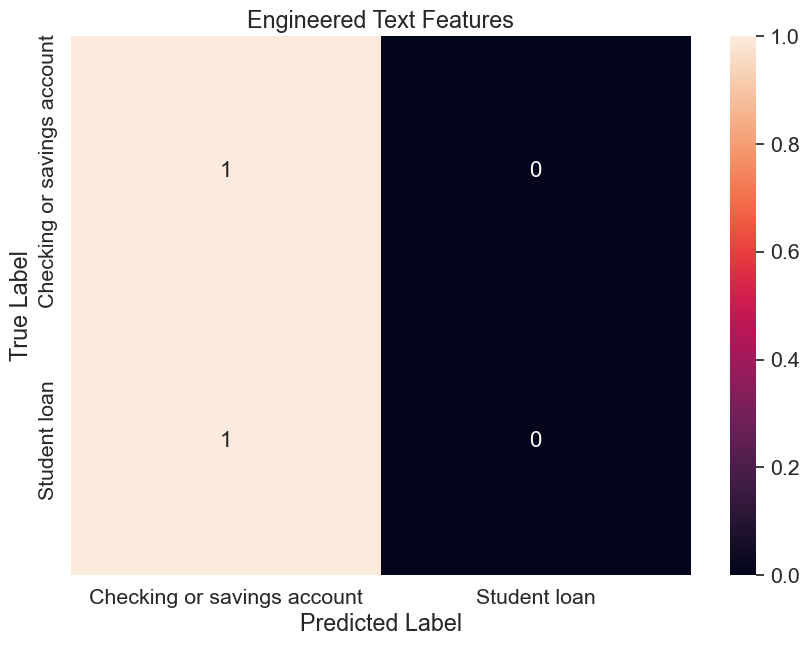

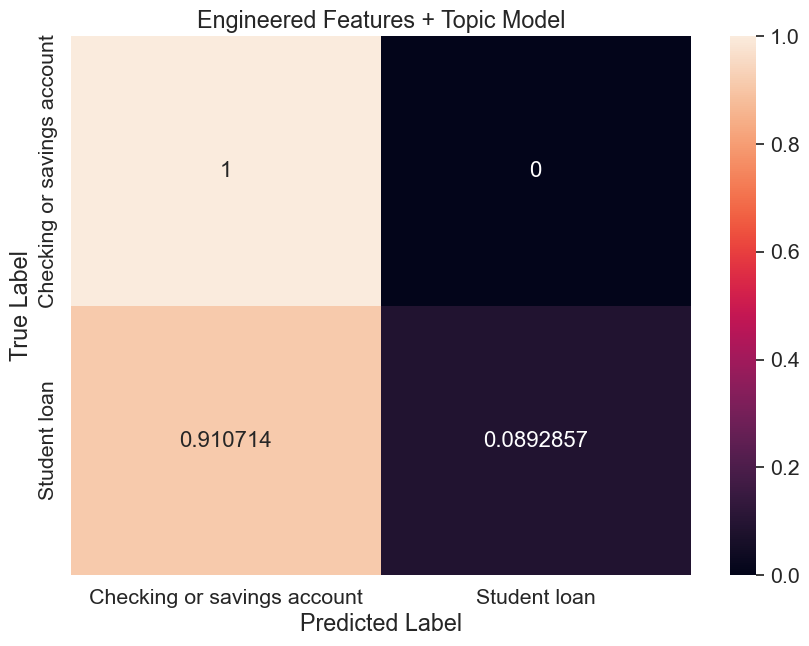

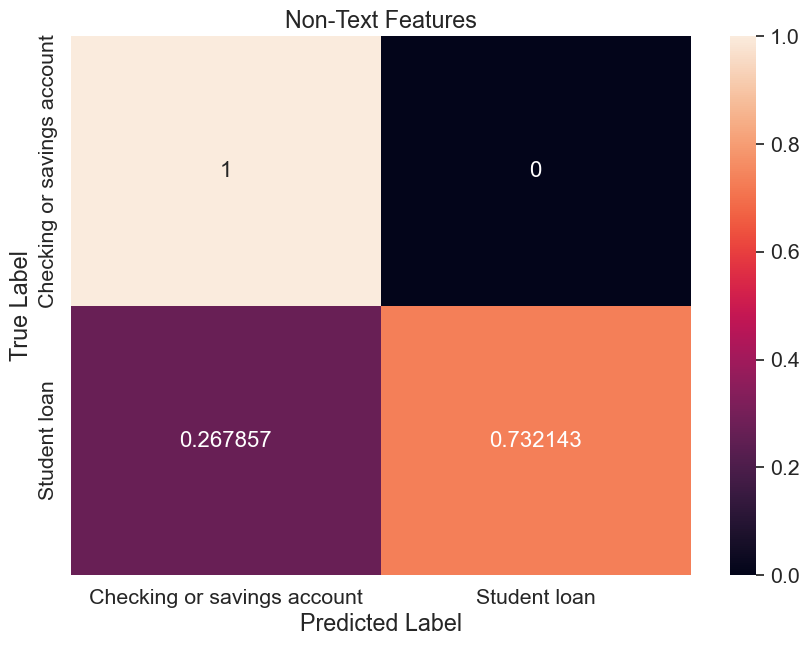

D:\Program\ANACONDA\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


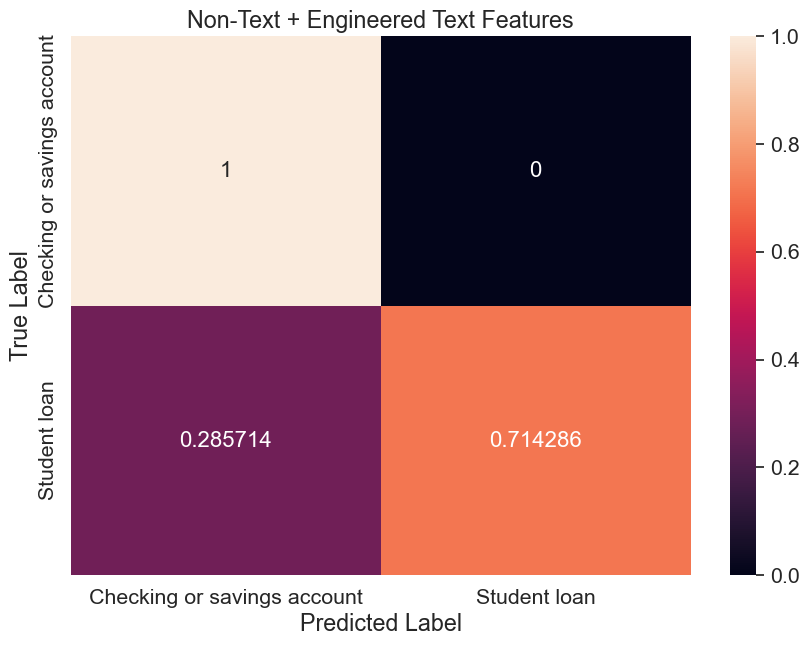

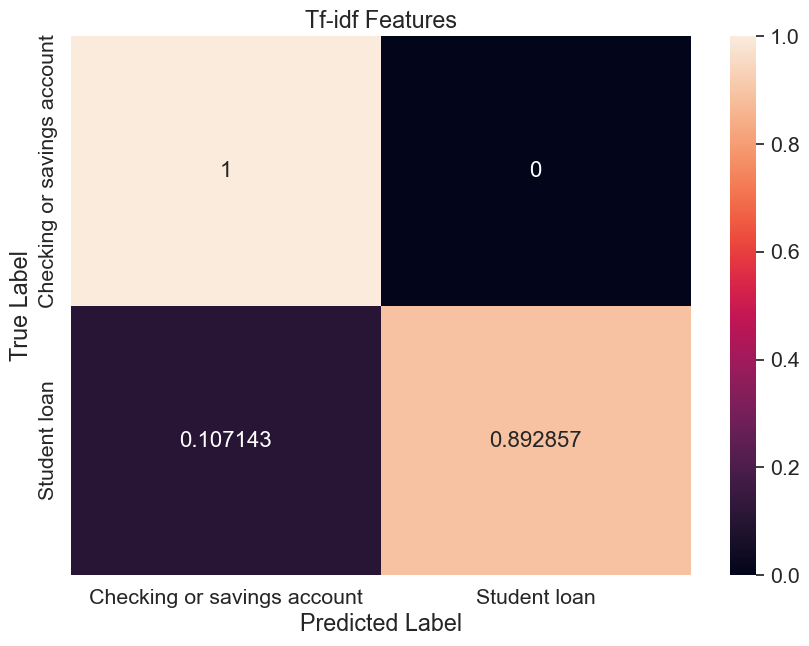

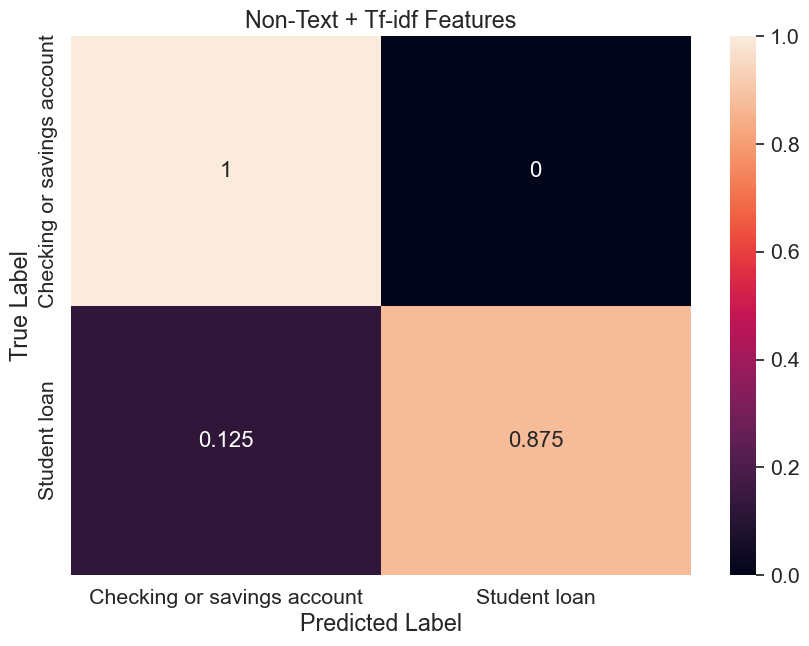

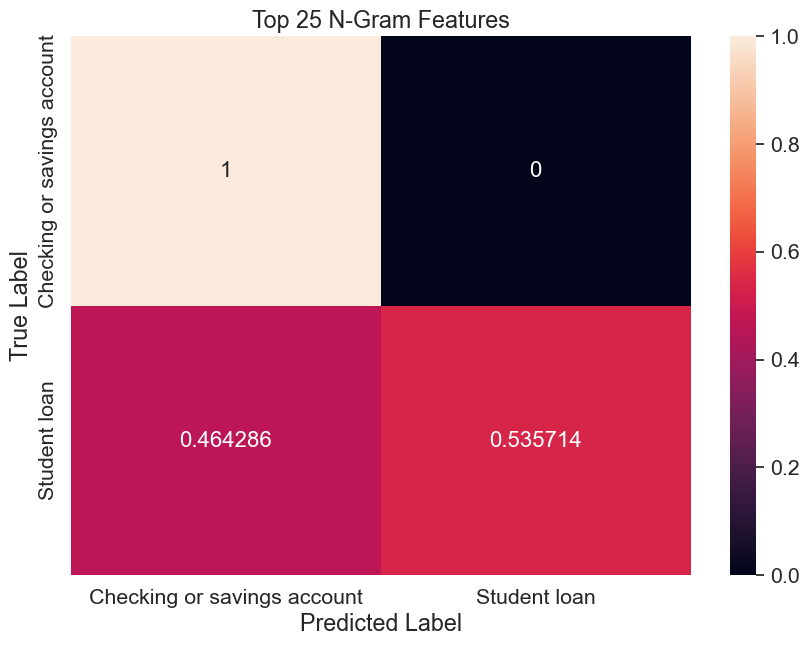

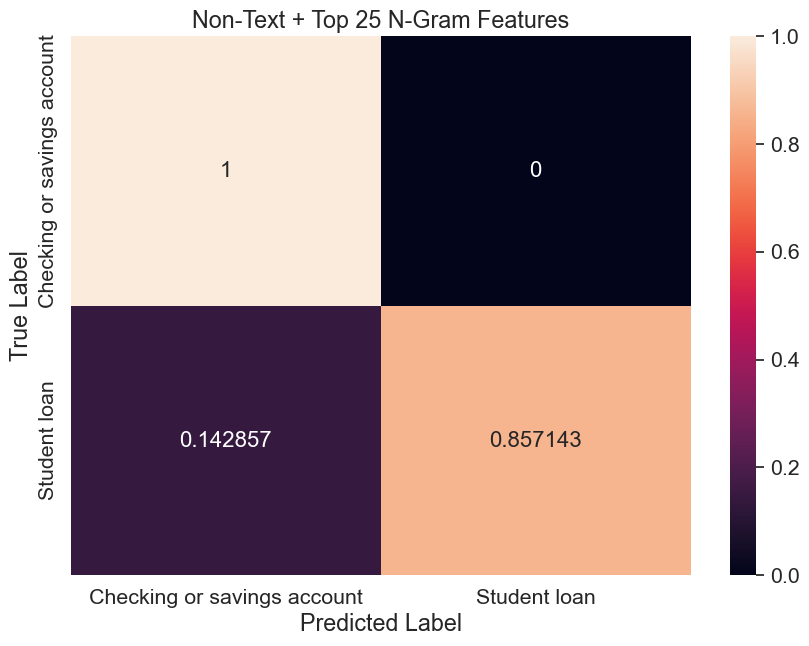

In [76]:
# loop over each dataframe, apply a logit classification model, and create a confusion matrix
# --------
for dataframe, featurization in zip(dataframes, featurization_technique):
    
    # changing column names to strings because some are integer
    dataframe.columns = dataframe.columns.astype(str) 
    
    # split data
    # ----------
    X_train, X_test, y_train, y_test = train_test_split(dataframe,         # specify features
                                                        y,                 # specify labels
                                                        train_size = .80,  # specify train split of 80%
                                                        test_size=0.20,    # specify test split of 20%
                                                        random_state = 10) # set seed for reproducibility
    # apply Logit model 
    # ----------
    # initalize Logit model 
    logit_reg = LogisticRegression() # set max_iter = 500

    # fit the model to our data
    logit_model = logit_reg.fit(X_train,          # specify feature data
                                y_train.ravel()) # specify label data --- don't forget to ravel the training dataset

    # predict on test set
    y_pred = logit_model.predict(X_test)      # predict on test data
    
    # create a confusion matrix
    # ----------
    cf_matrix = confusion_matrix(y_test,             # specify test
                                 y_pred,             # specify predicted
                                 normalize = "true") # normalize


    # create a pandas dataframe from the confusion matrix for visualization 
    df_cm = pd.DataFrame(cf_matrix,                # specify cf_matrix from which to create dataframe 
                         range(2), range(2)) # set 2 by 2 

    # set confusion matrix indices for clarity of visualization
    df_cm = df_cm.rename(index=str, 
                         columns={0: "Checking or savings account", 
                                  1: "Student loan"})

    # specify confusion matrix index for clarity
    df_cm.index = ["Checking or savings account", "Student loan"]
    
    # figure specifications 
    plt.figure(figsize = (10,7)) # set figure size specifications
    sns.set(font_scale=1.4)      # set label size
    sns.heatmap(df_cm,           # specify dataset
                annot=True,    
                annot_kws={"size": 16},
                fmt='g')
    
    # figure labels
    plt.title(featurization)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

## Discussion

In general, combing text with non-text features will improve a classifier's performance. However this isn't automatic - in some cases you can actually degrade a classifier's performance by adding in more features.

In this case, our engineered features were too quick to predict "checking or savings account" and our tf-idf alone outperformed tf-idf + non-text features. 

However, non-text features + n-grams was tied with tf-idf alone! We might prefer the former approach because it is computationally cheaper, and likely easier to explain.

## Naive Bayes

[Naive Bayes](https://scikit-learn.org/stable/modules/naive_bayes.html#:~:text=Naive%20Bayes%20methods%20are%20a,value%20of%20the%20class%20variable) is a supervised learning algorithim that leverages [Bayes’ theorem](https://en.wikipedia.org/wiki/Bayes%27_theorem) that is commonly used to solve classification problems. The "naive" of Naive Bayes comes from its assumption of conditional independence between every feature pair during estimation. In the context of Natural Language Processing, this means it assumes the probabilty a word will be chosen is independent of other words in the corpus. While this strong assumption seems to violate what we know about language, the model has proven time and time again to be very effective. 

* One important note, however, is that although naive Bayes is known as a decent classifier, [it is known to be a bad estimator](https://scikit-learn.org/stable/modules/naive_bayes.html#:~:text=Naive%20Bayes%20methods%20are%20a,value%20of%20the%20class%20variable.), so the probability outputs from `predict_proba` are not to be taken too seriously.*

Let's see how it compares to the logit models we just implemented. Note that we'll use the last dataframe (X_train) that was generated from the loop above ("Non-Text + Top 25 N-Gram Features"), so we should compare our results to the last confusion matrix.

* One last thing to note is that the library name for each model refers to the type of data used, not necessarily the outcome. So, we'll use Multinomial Naive Bayes because it works for text data not because we are modeling a multi-cateogry outcome. See this [Stack Overflow post] for more on the difference between the Naive Bayes libraries. *

In [77]:
# initialize the Multinomial Naive Bayes algorithim
# ----------
# load library
from sklearn.naive_bayes import MultinomialNB

# hyper parameter ??????????
# initialize the native bayes estimator
nb = MultinomialNB(alpha = 1 )   # see how performance changes with different levels of smoothing

# fit it on the training data
# ----------
nb_model = nb.fit(X_train, 
                  y_train.ravel()) # use the .ravel() method to flatten flatten multi-dimensional to 1-dimensional array

# predict on test dataset
# ----------
nb_pred = nb_model.predict(X_test) 

In [79]:
# print average accuracy
# ----------
print(np.mean(nb_pred == y_test))

# create a confusion matix
# ----------
nb_cf_matrix = confusion_matrix(y_test,  # specify test and predictions to compare
                                nb_pred, 
                                normalize = "true")

# print confusion matrix scores
print(nb_cf_matrix)

0.5924
[[0.97222222 0.02777778]
 [0.03571429 0.96428571]]


In [80]:
# convert to dataframe for visualization
# ----------
nb_df_cm = pd.DataFrame(nb_cf_matrix,       # set data to convert to dataframe
                        range(2),
                        range(2))

# visualize
nb_df_cm

,0,1
0,0.972222,0.027778
1,0.035714,0.964286


**QUESTION:** How does this compare to the Logit classification model from above?

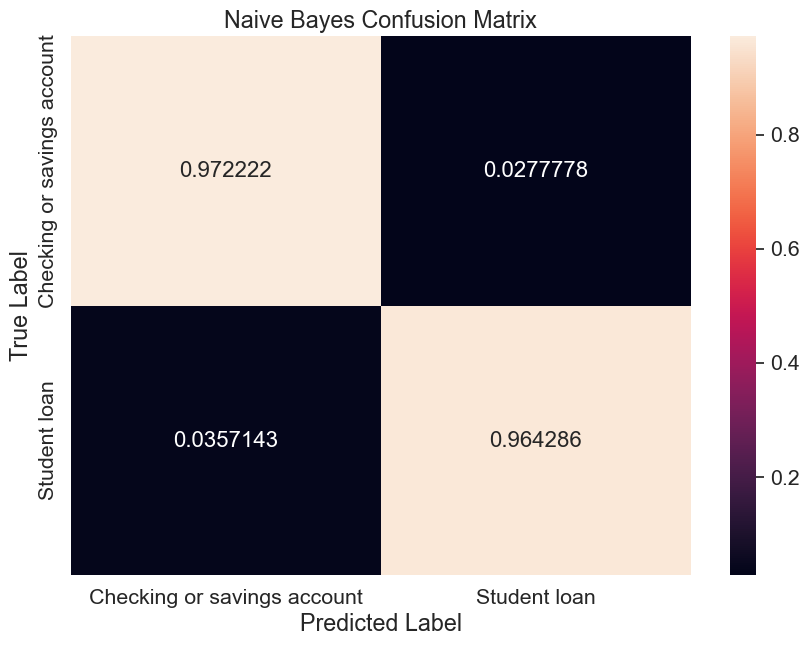

In [81]:
# create confusion matrix using Seaborn code
# ----------
# add indices and labels
nb_df_cm = nb_df_cm.rename(index=str, columns={0: "Checking or savings account", 
                                               1: "Student loan"})

nb_df_cm.index = ["Checking or savings account", "Student loan"]

# specifyc figure parameters
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size

# specify figure using seaborn library
sns.heatmap(nb_df_cm, 
           annot=True,
           annot_kws={"size": 16},
           fmt='g')  # prevent scientific notation

# figure labels
plt.title("Naive Bayes Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

**ANSWER:** ...

---
Notebook developed by Aniket Kesari. Modified by Prashant Sharma (2023) and by Kasey Zapatka (2024).